In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import date

pd.set_option('display.max_rows', 10)

In [2]:
#set conditions for a single timeseries
location = 'LIB'  #see reservoir dataframe below for options
startyr = 1928  #btwn 1929-2008 for nrni
endyr = 2008
special_years = [1934]  #for hydrograph, could be one or many

#set file locations
filepath = '/Users/vano/Dropbox/raid/rmjoc2/%s.csv'
filename = 'nrni/NRNI_Flows_1929-2008_Corrected_08-2016'
filepath%filename

#set path to output figures
filepathfigs = '/Users/vano/Desktop/'

In [3]:
#Information on possible locations and time periods

nongcm = ['nrni','livneh']
gcm = ['xxx', 'xxx']

reservoir = [{'LIB': 'Libby', 'DWO': 'Dworshak'} , # name
             {'LIB': 'LIB5N', 'DWO': 'XXX'},  # month forecast period starts
             {'LIB': 4, 'DWO': 4},  # month forecast period starts
             {'LIB': 8, 'DWO': 7},  # month forecast period ends
             {'LIB': 'April-August', 'DWO': 'April-July'},  # forecast period description
             {'LIB': 22}] # y-axis height for histogram
reservoir = pd.DataFrame(reservoir, index=['name', 'nrni_name', 'm_start', 'm_end', 'fcst_desc', 'hist_height'])

# bins for histogram
bins = pd.DataFrame([2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5], columns=['LIB']) 
bins['DWO'] = pd.DataFrame([-5, -3, 0, 10, 20, 30, 40, 50])

#DO TO:
#include values here in scripts
#add gcm and rcp information

In [4]:
#Read in files (currently set up for either UW simulations or NRNI)

#If flows from UW simulations
#
#

#If flows from NRNI
df = pd.read_csv(filepath%filename, skiprows=range(1, 7), usecols=range(1,199))
nrni=df[reservoir.loc["nrni_name","%s" % (location)]]

#note: nrni dataset had funny date assignment, since only have to read in once, manually assigning them
rng = pd.date_range('07/1/1928', periods=29312, freq='D')
ts = pd.Series(nrni.values, index=rng)  
ts = ts.astype(np.float)

#TO DO:
# add UW file read in

In [5]:
# helper functions for finding day of water year and water year

def water_day(indate):
    doy = indate.timetuple().tm_yday
    if doy >= 274:
        outdate = doy - 274
    else:
        outdate = doy + 91
    return outdate

def water_year(year, month):
    if month > 9:
        return year + 1
    return year

In [6]:
tdf = ts.to_frame('streamflow')
tdf['wyear'] = [water_year(i.year, i.month) for i in tdf.index]
tdf['dowy'] = [water_day(i) for i in tdf.index]

In [7]:
twy = pd.pivot_table(tdf, index='dowy', columns='wyear')['streamflow']
wy_median = pd.DataFrame(twy[range(startyr, endyr)].median(axis=1), columns=['median'])  #couldn't label as series

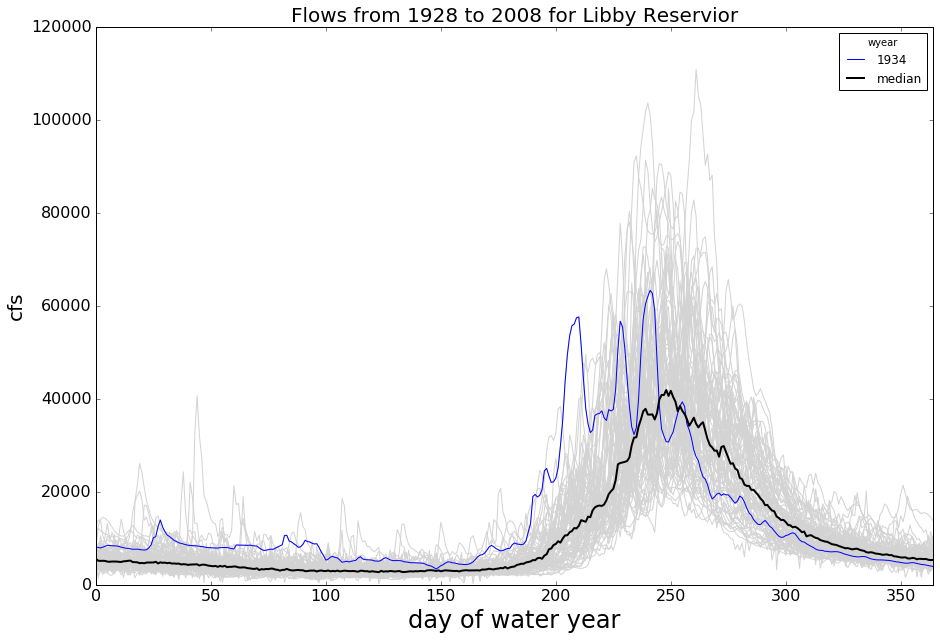

In [8]:
#hydrograph figure

fig, ax = plt.subplots(1, 1, figsize=(15, 10))

twy[range(startyr, endyr)].plot(c='lightgray', legend=False, ax=ax)
twy[special_years].plot(legend=True, ax=ax)
wy_median.plot(c='black', legend=True, linewidth=2, ax=ax, fontsize=16)

name = reservoir.loc["name","%s" % (location)]
plt.xlabel("day of water year", fontsize=24)
plt.ylabel("cfs", fontsize=20)
plt.title('Flows from %i to %i for %s Reservior' % (startyr, endyr, name), fontsize=20)
plt.rc('legend', fontsize=12) 

plt.savefig('%s/%s_hydrograph_%i-%i.pdf' % (filepathfigs, name, startyr, endyr))

# question: change size of legend, but plt.legend(fontsize=20) makes all years show up, the plt.rc doesn't change wyear
#TO DOS:
# eventually make y axis dates
# eventually do an if statement to remove special years if not highlighted above

In [9]:
#Calcuations for flow duration curve

x = tdf[ '%i-10-01' % (startyr) : '%i-09-30' % (endyr)].sort_values(by="streamflow", ascending=False)
dailysort=x['streamflow']

count = len(dailysort.values)

fdc = pd.DataFrame(dailysort.values, columns=['sorted']) 
fdc['count'] = pd.DataFrame(range(1,count+1))  
fdc['x'] = pd.DataFrame(100*fdc['count']/(count+1))

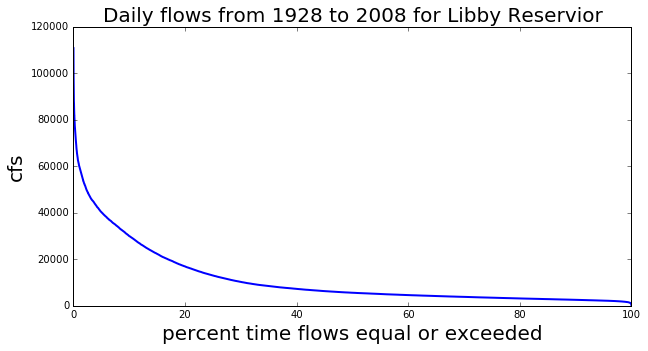

In [10]:
#flow duration curve figure

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

plt.plot(fdc['x'],fdc['sorted'], linewidth=2)

name = reservoir.loc["name","%s" % (location)]
plt.xlabel("percent time flows equal or exceeded", fontsize=20)
plt.ylabel("cfs", fontsize=20)
plt.title('Daily flows from %i to %i for %s Reservior' % (startyr, endyr, name), fontsize=20)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=14)

plt.savefig('%s/%s_flow_duration_curve_%i-%i.pdf' % (filepathfigs, name, startyr, endyr))

#question: odd. doesn't change plt.rc unless return in the box, a better way to do it?

In [11]:
#calculate forecast period in MAF

tdfstrm = tdf['streamflow']
tmm = tdfstrm[ '%i-10-01' % (startyr) : '%i-09-30' % (endyr)].resample('1MS', how='sum')
wsf = tmm[(tmm.index.month >= 4) & (tmm.index.month <= 8)].resample('AS', how='sum')
wsf_MAF = wsf*3600*24/43560/1000000

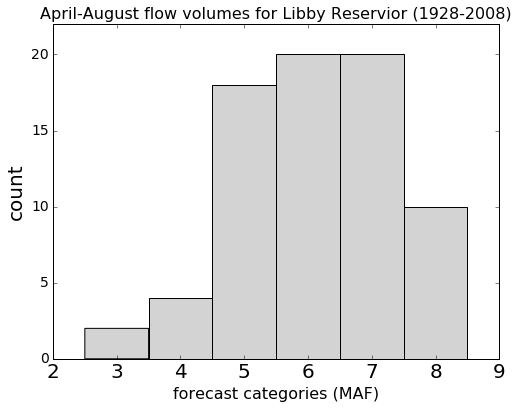

In [12]:
#histogram

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

plt.hist(wsf_MAF, bins=bins['%s' % (location)], color='lightgray')

name = reservoir.loc["name","%s" % (location)]
desc = reservoir.loc["fcst_desc","%s" % (location)]
plt.xlabel("forecast categories (MAF)", fontsize=16)
plt.ylabel("count", fontsize=20)
plt.title('%s flow volumes for %s Reservior (%i-%i)' % (desc, name, startyr, endyr), fontsize=16)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=14)
ax.set_ylim([0, reservoir.loc["hist_height","%s" % (location)]])

plt.savefig('%s/%s_water_supply_forecast_histogram_%i-%i.pdf' % (filepathfigs, name, startyr, endyr))

#TO DO:
#small thing: make bins into ranges
#figure out how to set yaxis to be a few bigger than largest bin, now set height in reservior df